# Markowitz资产组合优化

# 本段代码使用quantOS系统实现了Markowitz资产组合优化，并画出有效前沿。并比较两组股票组合有效前沿的差异

In [1]:
# encoding: utf-8
import sys
sys.path.insert(0, '/home/lli/JAQS/')
sys.path.append('/store/project/public/py/quantos/jzquant/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import matplotlib.mlab as mlab
import scipy.stats as stats
import cvxopt as opt
from cvxopt import blas, solvers

np.random.seed(100)
%matplotlib inline

In [2]:
from jaqs.data import RemoteDataService
import jaqs.util as jutil
from __future__ import print_function, unicode_literals, division, absolute_import

from jaqs.data import RemoteDataService, DataView

In [3]:
dataview_dir_path = '.'
backtest_result_dir_path = '.'

import os
phone = os.environ.get('QUANTOS_USER')
token = os.environ.get('QUANTOS_TOKEN')

data_config = {
  "remote.data.address": "tcp://data.quantos.org:8910",
  "remote.data.username": phone,
  "timeout": 3600,
  "remote.data.password": token
}

ds = RemoteDataService()
ds.init_from_config(data_config)


Begin: DataApi login 17321165656@tcp://data.quantos.org:8910
    login success 



u'0,'

## 获取资产日收益率数据

In [5]:
STARTDATE, ENDDATE = 20150101, 20180413

In [6]:
dataview_props = {# Start and end date of back-test
                  'start_date': STARTDATE, 'end_date': ENDDATE,
                  # Investment universe and performance benchmark
                  'universe': '000300.SH', 'benchmark': '000300.SH',
                  # Data fields that we need
                  # freq = 1 means we use daily data. Please do not change this.
                  'freq': 1}

# DataView utilizes RemoteDataService to get various data and store them
dv = DataView()
dv.init_from_config(dataview_props, ds)
dv.prepare_data()

Initialize config success.
Query data...
Query data - query...
NOTE: price adjust method is [post adjust]
220
441
662
220
441
662
Query data - daily fields prepared.
Query instrument info...
Query adj_factor...
Query benchmark...
Query benchmar member info...
Data has been successfully prepared.


## 由四只股票构成第一个股票组合

In [19]:
dv.add_formula('daily_ret', 'Return(close_adj, 1)', is_quarterly=False)

Field [daily_ret] is overwritten.


In [20]:
SYMBOLS = ['601318.SH', '601888.SH', '600887.SH', '002027.SZ']

In [21]:
daily_ret = dv.get_ts('daily_ret')

In [22]:
daily_ret = daily_ret.loc[:, SYMBOLS]

## 将其中一只股票收益率序列整体增加10 bps，构成第二个股票组合

In [ ]:
SHIFT = 0.001

In [23]:
daily_ret_shift = daily_ret.copy()
daily_ret_shift[SYMBOLS[3]] += SHIFT

In [24]:
daily_ret = daily_ret.dropna()
daily_ret_shift = daily_ret_shift.dropna()

In [25]:
return_vec = daily_ret.T.values
return_vec_shift = daily_ret_shift.T.values

## 模拟生成资产权重

In [26]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

## 生成资产组合

In [27]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
#     if sigma > 2:
#         return random_portfolio(returns)
    return mu, sigma

In [28]:
n_portfolios = 500
means1, stds1 = np.column_stack([random_portfolio(return_vec) for _ in range(n_portfolios)])
means2, stds2 = np.column_stack([random_portfolio(return_vec_shift) for _ in range(n_portfolios)])

## 对比以下两图可以发现资产组合的risk-return分布差别较大

Text(0.5,1,u'Mean and standard deviation of returns of portfolio1')

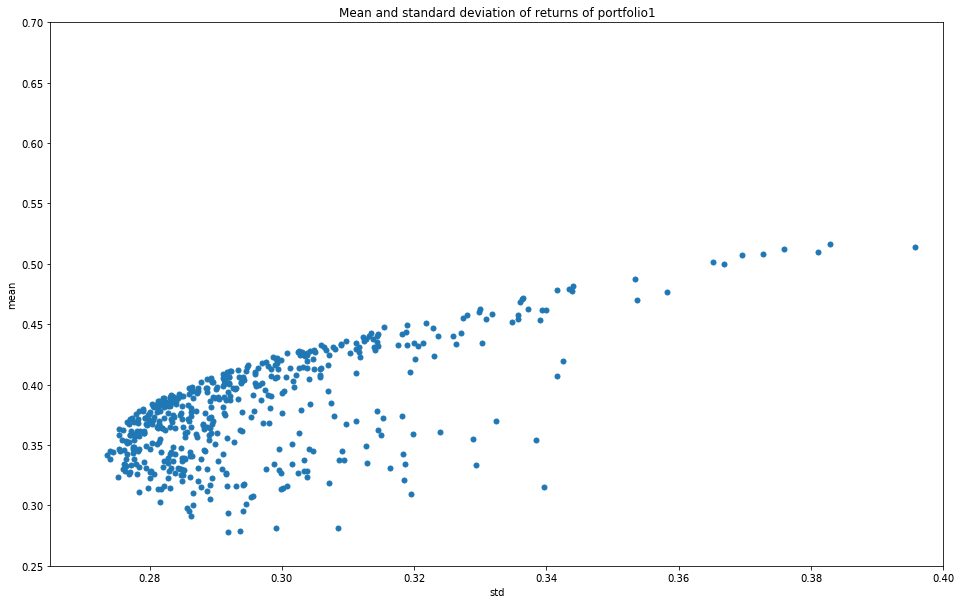

In [52]:
fig, ax = plt.subplots(figsize = (16,10))
plt.plot(stds1*np.sqrt(242), means1*242, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
ax.set_xlim(0.265, 0.4)
ax.set_ylim(0.25, 0.7)

plt.title('Mean and standard deviation of returns of portfolio1')

Text(0.5,1,u'Mean and standard deviation of returns of portfolio2')

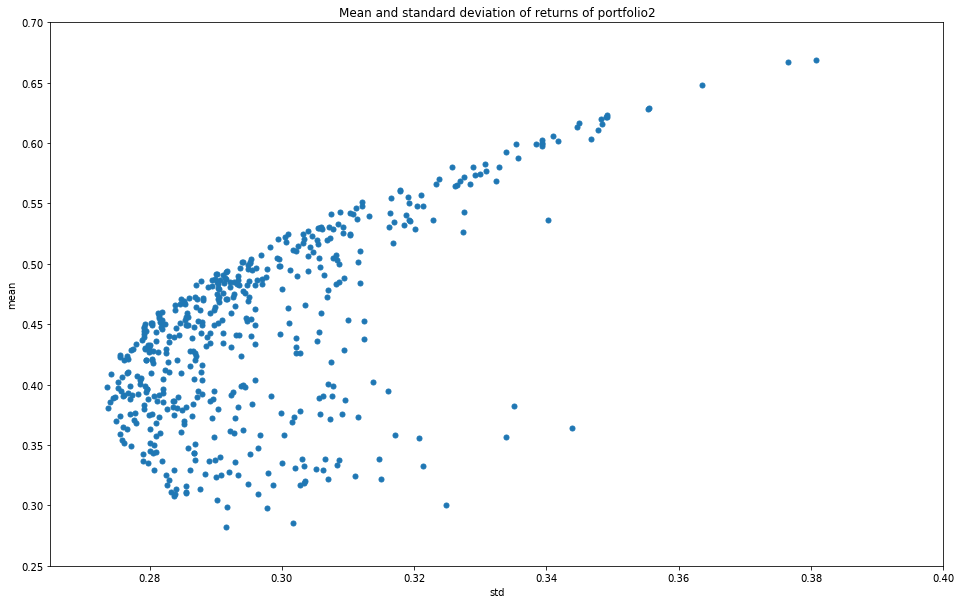

In [51]:
fig, ax = plt.subplots(figsize = (16,10))
plt.plot(stds2*np.sqrt(242), means2*242, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
ax.set_xlim(0.265, 0.4)
ax.set_ylim(0.25, 0.7)
plt.title('Mean and standard deviation of returns of portfolio2')

## 生成有效前沿

In [31]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights1, returns1, risks1 = optimal_portfolio(return_vec)
weights2, returns2, risks2 = optimal_portfolio(return_vec_shift)

     pcost       dcost       gap    pres   dres
 0: -1.5534e-03 -1.0025e+00  1e+00  2e-16  3e+00
 1: -1.5540e-03 -1.2468e-02  1e-02  9e-17  3e-02
 2: -1.6103e-03 -2.5646e-03  1e-03  1e-16  2e-03
 3: -2.4050e-03 -2.8075e-03  4e-04  4e-16  4e-04
 4: -2.4341e-03 -2.4398e-03  6e-06  3e-16  6e-06
 5: -2.4361e-03 -2.4361e-03  6e-08  2e-16  6e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5514e-03 -1.0025e+00  1e+00  2e-16  3e+00
 1: -1.5520e-03 -1.2465e-02  1e-02  6e-17  3e-02
 2: -1.6082e-03 -2.5616e-03  1e-03  8e-17  2e-03
 3: -2.4007e-03 -2.8000e-03  4e-04  2e-16  4e-04
 4: -2.4276e-03 -2.4332e-03  6e-06  2e-18  5e-06
 5: -2.4295e-03 -2.4296e-03  6e-08  1e-16  5e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5491e-03 -1.0025e+00  1e+00  0e+00  3e+00
 1: -1.5498e-03 -1.2462e-02  1e-02  1e-16  3e-02
 2: -1.6059e-03 -2.5581e-03  1e-03  1e-16  2e-03
 3: -2.3959e-03 -2.7916e-03  4e-04  4e-16  4e-04
 4: -2.4204e-03 -2.4259e

 1: -1.0548e-03 -1.1803e-02  1e-02  2e-16  3e-02
 2: -1.0865e-03 -1.8198e-03  7e-04  1e-16  2e-03
 3: -1.2029e-03 -1.3225e-03  1e-04  2e-16  4e-19
 4: -1.2150e-03 -1.2247e-03  1e-05  1e-16  3e-19
 5: -1.2160e-03 -1.2166e-03  7e-07  6e-17  2e-19
 6: -1.2160e-03 -1.2160e-03  2e-08  1e-16  1e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9151e-04 -1.0017e+00  1e+00  0e+00  3e+00
 1: -9.9188e-04 -1.1720e-02  1e-02  1e-16  3e-02
 2: -1.0212e-03 -1.7293e-03  7e-04  1e-16  2e-03
 3: -1.1173e-03 -1.2152e-03  1e-04  1e-16  2e-19
 4: -1.1252e-03 -1.1311e-03  6e-06  6e-17  5e-19
 5: -1.1254e-03 -1.1256e-03  2e-07  8e-17  3e-19
 6: -1.1254e-03 -1.1254e-03  2e-09  1e-16  7e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.2098e-04 -1.0016e+00  1e+00  2e-16  3e+00
 1: -9.2133e-04 -1.1626e-02  1e-02  6e-17  3e-02
 2: -9.4813e-04 -1.6285e-03  7e-04  1e-16  2e-03
 3: -1.0262e-03 -1.1040e-03  8e-05  7e-17  3e-19
 4: -1.0309e-03 -1.0344

 1:  1.5605e-01  1.1193e-01  4e-02  4e-17  1e-01
 2:  1.5298e-01  1.5027e-01  3e-03  4e-17  1e-16
 3:  1.5297e-01  1.5294e-01  3e-05  1e-16  5e-17
 4:  1.5297e-01  1.5297e-01  3e-07  1e-16  8e-17
 5:  1.5297e-01  1.5297e-01  3e-09  1e-16  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.7638e-01 -8.6923e-01  1e+00  2e-16  3e+00
 1:  1.7496e-01  1.2885e-01  5e-02  2e-16  1e-01
 2:  1.7182e-01  1.6916e-01  3e-03  1e-16  2e-16
 3:  1.7180e-01  1.7177e-01  3e-05  2e-16  8e-17
 4:  1.7180e-01  1.7180e-01  3e-07  1e-16  9e-17
 5:  1.7180e-01  1.7180e-01  3e-09  9e-17  3e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9775e-01 -8.5142e-01  1e+00  1e-16  3e+00
 1:  1.9613e-01  1.4811e-01  5e-02  1e-16  1e-01
 2:  1.9296e-01  1.9038e-01  3e-03  4e-17  1e-16
 3:  1.9294e-01  1.9291e-01  3e-05  1e-16  6e-17
 4:  1.9294e-01  1.9294e-01  3e-07  8e-17  1e-16
 5:  1.9294e-01  1.9294e-01  3e-09  9e-17  8e-17
Optimal solution found.

 4: -3.1055e-03 -3.1140e-03  8e-06  2e-16  8e-19
 5: -3.1094e-03 -3.1095e-03  8e-08  2e-19  9e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6927e-03 -1.0033e+00  1e+00  2e-16  3e+00
 1: -1.6945e-03 -1.3316e-02  1e-02  1e-16  3e-02
 2: -1.8457e-03 -3.3720e-03  2e-03  9e-17  4e-03
 3: -2.9901e-03 -3.5049e-03  5e-04  1e-16  5e-19
 4: -3.0573e-03 -3.0674e-03  1e-05  2e-16  1e-18
 5: -3.0630e-03 -3.0631e-03  1e-07  1e-16  6e-19
 6: -3.0630e-03 -3.0630e-03  1e-09  2e-16  4e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6769e-03 -1.0033e+00  1e+00  2e-16  3e+00
 1: -1.6787e-03 -1.3295e-02  1e-02  1e-16  3e-02
 2: -1.8282e-03 -3.3457e-03  2e-03  6e-17  4e-03
 3: -2.9200e-03 -3.4378e-03  5e-04  2e-16  8e-19
 4: -3.0030e-03 -3.0152e-03  1e-05  2e-16  8e-19
 5: -3.0109e-03 -3.0110e-03  1e-07  1e-16  9e-19
 6: -3.0110e-03 -3.0110e-03  1e-09  2e-16  4e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres


 1:  2.3796e-02  5.4885e-03  2e-02  1e-16  5e-02
 2:  2.2923e-02  2.0985e-02  2e-03  7e-17  3e-03
 3:  2.2847e-02  2.2803e-02  4e-05  2e-16  2e-05
 4:  2.2847e-02  2.2847e-02  4e-07  1e-16  2e-07
 5:  2.2847e-02  2.2847e-02  4e-09  1e-16  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.6967e-02 -9.8272e-01  1e+00  4e-16  3e+00
 1:  2.6893e-02  7.6166e-03  2e-02  2e-16  5e-02
 2:  2.5902e-02  2.3987e-02  2e-03  1e-16  2e-03
 3:  2.5834e-02  2.5794e-02  4e-05  8e-17  2e-05
 4:  2.5834e-02  2.5834e-02  4e-07  6e-17  2e-07
 5:  2.5834e-02  2.5834e-02  4e-09  6e-17  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.0455e-02 -9.8039e-01  1e+00  2e-16  3e+00
 1:  3.0363e-02  1.0031e-02  2e-02  2e-16  5e-02
 2:  2.9245e-02  2.7380e-02  2e-03  4e-17  2e-03
 3:  2.9186e-02  2.9150e-02  4e-05  4e-17  2e-05
 4:  2.9186e-02  2.9185e-02  4e-07  1e-16  2e-07
 5:  2.9186e-02  2.9186e-02  4e-09  1e-16  2e-09
Optimal solution found.

## 对比以下两图可以发现资产组合的有效前沿差别较大

Text(0.5,1,u'Efficient Frontier of portfolio1')

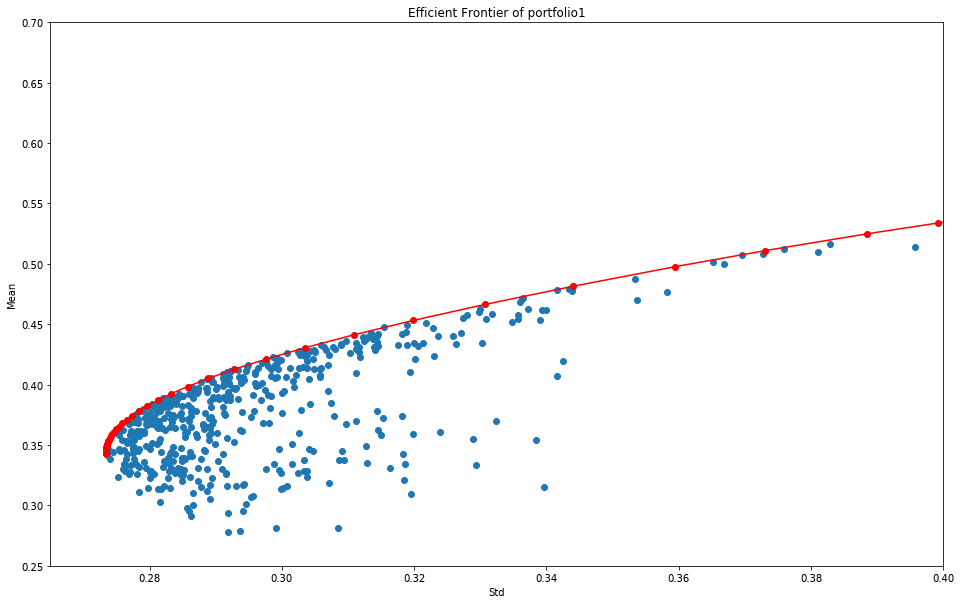

In [53]:
fig, ax = plt.subplots(figsize = (16,10))
plt.plot(stds1*np.sqrt(242), means1 * 242, 'o')
plt.ylabel('Mean')
plt.xlabel('Std')
ax.set_xlim(0.265, 0.4)
ax.set_ylim(0.25, 0.7)
plt.plot(np.array(risks1)*np.sqrt(242), np.array(returns1) * 242, 'y-o', color = 'red')
plt.title('Efficient Frontier of portfolio1')

Text(0.5,1,u'Efficient Frontier of portfolio2')

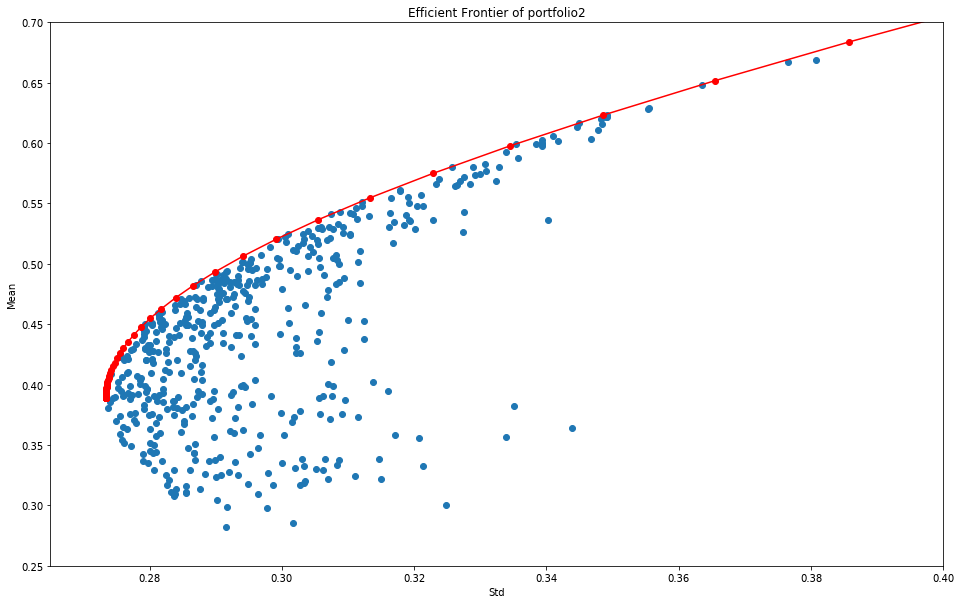

In [54]:
fig, ax = plt.subplots(figsize = (16,10))
plt.plot(stds2*np.sqrt(242), means2 * 242, 'o')
plt.ylabel('Mean')
plt.xlabel('Std')
ax.set_xlim(0.265, 0.4)
ax.set_ylim(0.25, 0.7)

plt.plot(np.array(risks2)*np.sqrt(242), np.array(returns2) * 242, 'y-o', color = 'red')
plt.title('Efficient Frontier of portfolio2')